In [ ]:
import numpy
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
## Neural network class
class PINN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers):
    super(PINN, self).__init__()
    activation = nn.Tanh
    self.input_layer = nn.Linear(input_size, hidden_size)
    self.hidden_layers = nn.ModuleList([nn.Sequential(nn.Linear(hidden_size, hidden_size),activation()) for _ in range(num_layers)])
    self.output_layer = nn.Linear(hidden_size, output_size)

  def forward(self, x, t):
    input_data = torch.cat((x, t), -1)
    output = torch.tanh(self.input_layer(input_data))
    for layer in self.hidden_layers:
      output = layer(output)
    output = self.output_layer(output)
    return output

In [ ]:
## Defining the heat PDE
def heat_equation(T, x, t, alpha):
    T_x = torch.autograd.grad(T, x, torch.ones_like(T), create_graph=True)[0]
    T_t = torch.autograd.grad(T, t, torch.ones_like(T), create_graph=True)[0]
    T_xx = torch.autograd.grad(T_x, x, torch.ones_like(T), create_graph=True)[0]
    return T_t - alpha * T_xx

In [ ]:
## PDE training data
x1 = torch.linspace(0, 1, 101).view(-1, 1)
t1 = torch.linspace(0, 5, 11).view(-1, 1)
x1 = x1.view(-1)
t1 = t1.view(-1)
x_train1, t_train1 = torch.meshgrid(x1, t1)
x_train1 = x_train1.reshape(1111, 1).requires_grad_(True)
t_train1 = t_train1.reshape(1111, 1).requires_grad_(True)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
## Initial condition training data
x2 = torch.linspace(0, 1, 101).view(-1, 1)
t2 = torch.tensor(0.)
x2 = x2.view(-1)
t2 = t2.view(-1)
x_train2, t_train2 = torch.meshgrid(x2, t2)
x_train_initial = x_train2.reshape(101, 1).requires_grad_(True)
t_train_initial = t_train2.reshape(101, 1).requires_grad_(True)
# T_train_initial = torch.ones_like(x_train_initial)*x_train_initial*(10 - x_train_initial)
T_train_initial = torch.ones_like(x_train_initial)*torch.sin(math.pi*x_train_initial)

In [ ]:
## Boundary condition training data
x3 = torch.tensor([[0. ,1.]]).view(-1, 1)
t3 = torch.linspace(0, 5, 11).view(-1, 1)
x3 = x3.view(-1)
t3 = t3.view(-1)
x_train3, t_train3 = torch.meshgrid(x3, t3)
x_train_boundary = x_train3.reshape(22, 1).requires_grad_(True)
t_train_boundary = t_train3.reshape(22, 1).requires_grad_(True)
T_train_boundary = torch.ones_like(x_train_boundary)*0

In [ ]:
## Initialization of PINN
torch.manual_seed(69)
pinn = PINN(2,40,1,10)
optimizer = torch.optim.Adam(pinn.parameters(), lr=0.0001)

In [ ]:
## Training Loop
epochs = 50000
loss_history = []
for epoch in range(epochs):

  optimizer.zero_grad()

  T_pred = pinn(x_train1,t_train1)
  pde_loss = heat_equation(T_pred, x_train1, t_train1,0.1).pow(2).mean()

  T_pred_initial = pinn(x_train_initial,t_train_initial)
  initial_condition_loss = (T_pred_initial - T_train_initial).pow(2).mean()

  T_pred_boundary = pinn(x_train_boundary,t_train_boundary)
  boundary_condition_loss = (T_pred_boundary - T_train_boundary).pow(2).mean()

  p1 = 1
  p2 = 1
  total_loss = pde_loss + p1*initial_condition_loss + p2*boundary_condition_loss

  total_loss.backward(retain_graph=True)
  optimizer.step()
  loss_history.append(total_loss.item())
  if epoch % 10000 == 0:
      print(f"Epoch {epoch}/{epochs}, Total Loss: {total_loss.item()}, pde Loss: {pde_loss.item()}, Initial Loss: {initial_condition_loss.item()}, Boundary Loss: {boundary_condition_loss.item()}")

Epoch 0/50000, Total Loss: 0.6213634610176086, pde Loss: 7.192065965000438e-08, Initial Loss: 0.6137241721153259, Boundary Loss: 0.007639234885573387
Epoch 10000/50000, Total Loss: 5.308155596139841e-05, pde Loss: 4.854402141063474e-05, Initial Loss: 1.6368900332963676e-06, Boundary Loss: 2.900643266912084e-06
Epoch 20000/50000, Total Loss: 3.398502303753048e-05, pde Loss: 3.1398758437717333e-05, Initial Loss: 6.157653729133017e-07, Boundary Loss: 1.9704993974301033e-06
Epoch 30000/50000, Total Loss: 2.754899105639197e-05, pde Loss: 2.0778985344804823e-05, Initial Loss: 3.4259649055456975e-06, Boundary Loss: 3.3440419429098256e-06
Epoch 40000/50000, Total Loss: 6.210162155184662e-06, pde Loss: 5.695980235032039e-06, Initial Loss: 7.6135513893405e-08, Boundary Loss: 4.380464702080644e-07


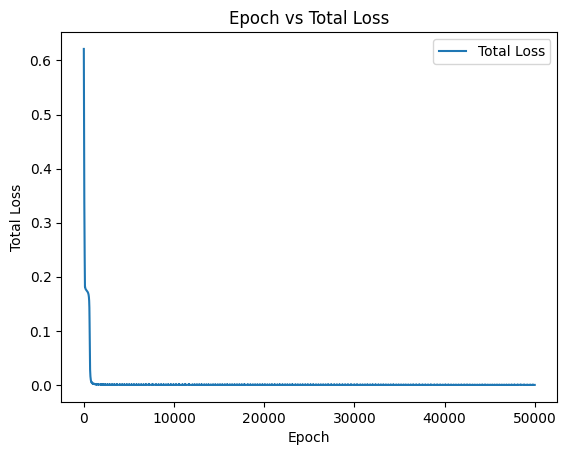

In [ ]:
## Plot for Epoch vs Total Loss
plt.plot(range(epochs), loss_history, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Epoch vs Total Loss')
plt.legend()
plt.show()

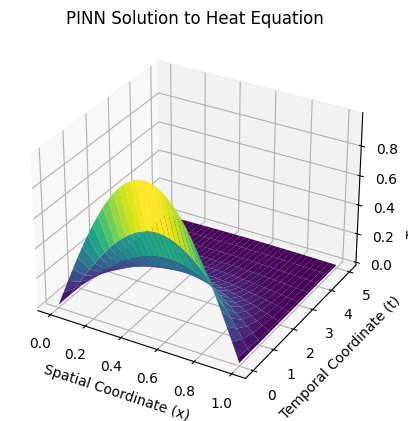

In [ ]:
## 3D plot
with torch.no_grad():
    x_plot = torch.linspace(0, 1, 101)
    t_plot = torch.linspace(0, 5, 11)
    X, T = torch.meshgrid(x_plot, t_plot)
    xt_combined = torch.cat([X.reshape(-1, 1), T.reshape(-1, 1)], dim=1)
    T_pred_plot = pinn(xt_combined[:, 0].unsqueeze(1), xt_combined[:, 1].unsqueeze(1)).detach().numpy().reshape(X.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X.numpy(), T.numpy(), T_pred_plot, cmap='viridis')
ax.set_xlabel('Spatial Coordinate (x)')
ax.set_ylabel('Temporal Coordinate (t)')
ax.set_zlabel('Temperature (T)')
ax.set_title('PINN Solution to Heat Equation')
plt.show()

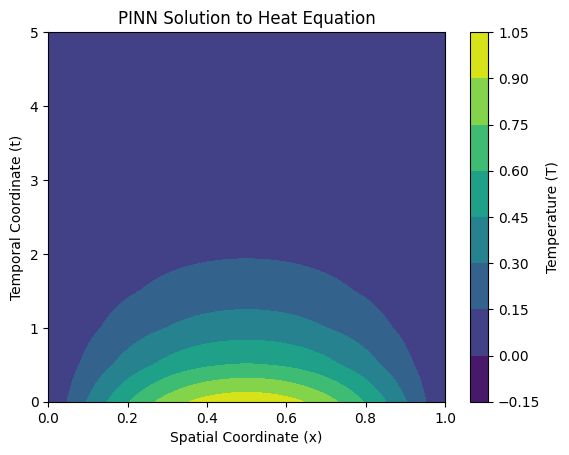

In [ ]:
## 2D contour plot
plt.figure()
contour = plt.contourf(X.numpy(), T.numpy(), T_pred_plot, cmap='viridis')
plt.colorbar(contour, label='Temperature (T)')
plt.xlabel('Spatial Coordinate (x)')
plt.ylabel('Temporal Coordinate (t)')
plt.title('PINN Solution to Heat Equation')
plt.show()

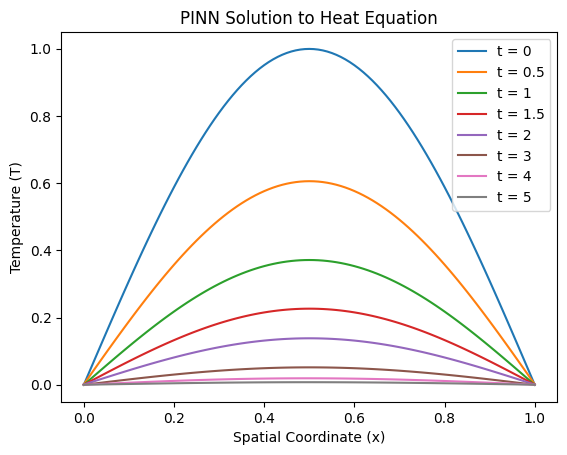

In [ ]:
with torch.no_grad():
    x_plot2 = torch.linspace(0, 1, 101)
    t_points = [0, 0.5, 1, 1.5, 2, 3, 4, 5]

    plt.figure()

    for t_point in t_points:
        t_plot2 = torch.ones_like(x_plot2) * t_point
        xt_combined = torch.cat([x_plot2.reshape(-1, 1), t_plot2.reshape(-1, 1)], dim=1)

        T_pred_plot2 = pinn(xt_combined[:, 0].unsqueeze(1), xt_combined[:, 1].unsqueeze(1)).detach().numpy()

        plt.plot(x_plot2.numpy(), T_pred_plot2, label=f't = {t_point}')

    plt.xlabel('Spatial Coordinate (x)')
    plt.ylabel('Temperature (T)')
    plt.title('PINN Solution to Heat Equation')
    plt.legend()
    plt.show()

In [ ]:
# ## Adding Gaussian noise to the Temperature data
# mean = 0
# std_dev = 0.1
# gaussian_noise = numpy.random.normal(mean, std_dev, T_pred_plot.shape)
# # T_noise_ = T_pred_plot + gaussian_noise
# # T_noise = torch.tensor(T_noise_)

In [ ]:
## Actual training data for Inverse PINN
x_test = torch.tensor([0.2, 0.4, 0.6, 0.8])
t_test = torch.tensor([2.0, 3.0, 4.0])
x = x_test.requires_grad_(True).reshape(4, 1)
t = t_test.requires_grad_(True).reshape(3, 1)
x = x.view(-1)
t = t.view(-1)
x_train, t_train = torch.meshgrid(x, t)
x_train = x_train.reshape(12, 1).requires_grad_(True)
t_train = t_train.reshape(12, 1).requires_grad_(True)
T_train_actual = pinn(x_train,t_train)
T_train_actual = T_train_actual.detach().numpy()
## Adding Gaussian noise to the Temperature data
mean = 0
std_dev = 0.05
gaussian_noise = numpy.random.normal(mean, std_dev, T_train_actual.shape)
T_noise_ = T_train_actual + gaussian_noise
T_noise = torch.tensor(T_noise_)
T_train_actual = T_noise.requires_grad_(True)

In [ ]:
## PDE training data
x1 = torch.linspace(0, 1, 101).view(-1, 1)
t1 = torch.linspace(0, 5, 11).view(-1, 1)
x1 = x1.view(-1)
t1 = t1.view(-1)
x_train1, t_train1 = torch.meshgrid(x1, t1)
x_train1 = x_train1.reshape(1111, 1).requires_grad_(True)
t_train1 = t_train1.reshape(1111, 1).requires_grad_(True)

In [ ]:
## Initial condition training data
x2 = torch.linspace(0, 1, 101).view(-1, 1)
t2 = torch.tensor(0.)
x2 = x2.view(-1)
t2 = t2.view(-1)
x_train2, t_train2 = torch.meshgrid(x2, t2)
x_train_initial = x_train2.reshape(101, 1).requires_grad_(True)
t_train_initial = t_train2.reshape(101, 1).requires_grad_(True)
# T_train_initial = torch.ones_like(x_train_initial)*x_train_initial*(10 - x_train_initial)
T_train_initial = torch.ones_like(x_train_initial)*torch.sin(math.pi*x_train_initial)

In [ ]:
## Boundary condition training data
Temp1val = 0.
Temp2val = 0.
Temperature1 = torch.tensor([Temp1val], requires_grad=True)
Temperature2 = torch.tensor([Temp2val], requires_grad=True)
x3_1 = torch.tensor([0.]).view(-1, 1)
x3_2 = torch.tensor([1.]).view(-1, 1)
t3 = torch.linspace(0, 5, 11).view(-1, 1)
x3_1 = x3_1.view(-1)
x3_2 = x3_2.view(-1)
t3 = t3.view(-1)
x_train3_1, t_train3 = torch.meshgrid(x3_1, t3)
x_train3_2, t_train3 = torch.meshgrid(x3_2, t3)
x_train_boundary1 = x_train3_1.reshape(11, 1).requires_grad_(True)
x_train_boundary2 = x_train3_2.reshape(11, 1).requires_grad_(True)
t_train_boundary = t_train3.reshape(11, 1).requires_grad_(True)

In [ ]:
## Initialization of Inverse PINN
alpha0 = torch.tensor([1.], requires_grad=True)
torch.manual_seed(68)
pinn2 = PINN(2,40,1,10)
parameters = [
    {'params': pinn2.parameters(), 'lr': 0.0002},
    {'params': [alpha0], 'lr': 0.01}
]
optimizer = torch.optim.Adam(parameters)

In [ ]:
## Training Loop
epochs = 100000
loss_history = []
for epoch in range(epochs):

  optimizer.zero_grad()

  T_pred_actual = pinn2(x_train,t_train)
  Actual_loss = (T_pred_actual - T_train_actual).pow(2).mean()

  T_pred = pinn2(x_train1,t_train1)
  # alpha0 = alpha0.detach().numpy()
  pde_loss = heat_equation(T_pred, x_train1, t_train1, alpha0).pow(2).mean()

  T_pred_initial = pinn2(x_train_initial,t_train_initial)
  initial_condition_loss = (T_pred_initial - T_train_initial).pow(2).mean()

  T_train_boundary1 = Temperature1.expand(11, 1)
  T_train_boundary2 = Temperature2.expand(11, 1)
  T_pred_boundary1 = pinn2(x_train_boundary1,t_train_boundary)
  T_pred_boundary2 = pinn2(x_train_boundary2,t_train_boundary)
  boundary_condition_loss = (T_pred_boundary1 - T_train_boundary1).pow(2).mean() + (T_pred_boundary2 - T_train_boundary2).pow(2).mean()

  p1 = 1
  p2 = 1
  p3 = 1
  total_loss = Actual_loss + p1*pde_loss + p2*initial_condition_loss + p3*boundary_condition_loss

  total_loss.backward(retain_graph=True)
  optimizer.step()
  loss_history.append(total_loss.item())
  if epoch % 5000 == 0:
      print(f"Epoch {epoch}/{epochs}, Total Loss: {total_loss.item()}, pde Loss: {pde_loss.item()}, Initial Loss: {initial_condition_loss.item()}, Boundary Loss: {boundary_condition_loss.item()}, alpha: {alpha0.item()}")

Epoch 0/100000, Total Loss: 0.8460518191682319, pde Loss: 7.90845220421943e-08, Initial Loss: 0.738714337348938, Boundary Loss: 0.058329008519649506, alpha: 0.9923998713493347
Epoch 5000/100000, Total Loss: 0.0014372585306282601, pde Loss: 0.00016209545719902962, Initial Loss: 4.487398655328434e-06, Boundary Loss: 6.447873602155596e-05, alpha: 0.11257684975862503
Epoch 10000/100000, Total Loss: 0.0015062724601066578, pde Loss: 0.0001092179591068998, Initial Loss: 7.842017657821998e-05, Boundary Loss: 9.23436600714922e-05, alpha: 0.11259415000677109
Epoch 15000/100000, Total Loss: 0.0013212641100177587, pde Loss: 0.0001096504129236564, Initial Loss: 8.684294698468875e-06, Boundary Loss: 5.395518383011222e-05, alpha: 0.1111602932214737
Epoch 20000/100000, Total Loss: 0.001314397593639882, pde Loss: 0.0001087290802388452, Initial Loss: 8.97567588253878e-06, Boundary Loss: 5.4616677516605705e-05, alpha: 0.11133384704589844
Epoch 25000/100000, Total Loss: 0.001289319500422009, pde Loss: 0.0

In [ ]:
print(alpha0.item())

0.11014357954263687
